# 1.3) The FitzHugh-Nagumo Model

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
from functools import partial
import numpy as np
import scipy.integrate
import scipy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

## Simulation Questions

## 1)

In [60]:
# Implementation of the Fitzhugh-Nagumo model
scenarios = [
     {"a":-.3, "b":1.4, "tau":20, "I":0},
     {"a":-.3, "b":1.4, "tau":20, "I":0.2},
     {"a":-.3, "b":1.4, "tau":20, "I":0.7}
]
time_span = np.linspace(0, 200, num=1500)
# Fitzhugh-Nagumo  neuron
def fitzhugh_nagumo(x, t, a, b, tau, I):
    return np.array([x[0] - x[0]**3 - x[1] + I,(x[0] - a - b * x[1])/tau])

def get_displacement(param, dmax=0.5,time_span=np.linspace(0,200, 1000), number=20):
    ic = scipy.integrate.odeint(partial(fitzhugh_nagumo, **param),y0=[0,0], t= np.linspace(0,999, 1000))[-1]
    traj = [] 
    for displacement in np.linspace(0,dmax, number):
        traj.append(scipy.integrate.odeint(partial(fitzhugh_nagumo, **param),y0=ic+np.array([displacement,0]),t=time_span))
    return traj

In [61]:
# store the trajectories
trajectories = {}
for i,param in enumerate(scenarios):
    trajectories[i] = get_displacement(param, number=3, time_span=time_span, dmax=0.5)

In [62]:
# Plot the nullclines
def plot_nullcline(ax, a, b, tau, I, color='k', style='--', opacity=.5, vmin=-2.5,vmax=2.5):
    v = np.linspace(vmin,vmax,100)
    ax.plot(v, v - v**3 + I, style, color=color, alpha=opacity)
    ax.plot(v, (v - a)/b, style, color=color, alpha=opacity)

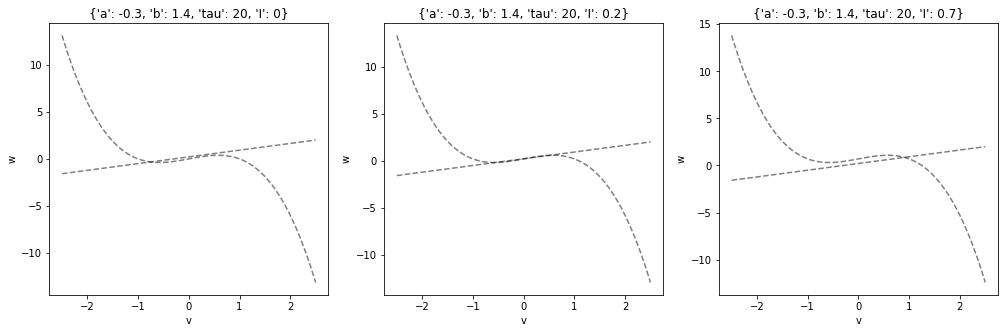

In [63]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5))
for i, sc in enumerate(scenarios):
    plot_nullcline(ax[i], **sc)
    ax[i].set(xlabel='v', ylabel='w',title='{}'.format(sc))

## 2)

In [51]:
# Compute the vector field
def plot_vector_field(ax, param, xrange, yrange, steps=50):
    x = np.linspace(xrange[0], xrange[1], steps)
    y = np.linspace(yrange[0], yrange[1], steps)
    X,Y = np.meshgrid(x,y)
    
    dx,dy = fitzhugh_nagumo([X,Y],0,**param)   
    ax.streamplot(X,Y,dx, dy, color=(0,0,0,.1))
    ax.set(xlim=(xrange[0], xrange[1]), ylim=(yrange[0], yrange[1]))

In [52]:
def find_roots(a,b,I, tau):
    coef = [1, 0, 1/b - 1, - a/b - I]
    roots = [np.real(r) for r in np.roots(coef) if np.isreal(r)]
    return [[r, r - r**3 + I] for r in roots]

eqnproot = {}
for i, param in enumerate(scenarios):
    eqnproot[i] = find_roots(**param)

In [53]:
EQUILIBRIUM_COLOR = {'Stable node':'C0','Unstable node':'C1','Saddle':'C4','Stable focus':'C3','Unstable focus':'C2','Center':'C5'}

In [54]:
# Implement the jacobian of the system
def jacobian_fitznagumo(v, w, a, b, tau, I):
    return np.array([[- 3 * v**2 + 1 , -1],[1/tau, -b/tau]])

In [55]:
# Symbolic computation of the Jacobian using sympy... 
import sympy 
sympy.init_printing()

# Define variable as symbols for sympy
v, w = sympy.symbols("v, w")
a, b, tau, I = sympy.symbols("a, b, tau, I")

# Symbolic expression of the system
dvdt = v - v**3 - w + I
dwdt = (v - a - b * w)/tau

# Symbolic expression of the matrix
sys = sympy.Matrix([dvdt, dwdt])
var = sympy.Matrix([v, w])
jac = sys.jacobian(var)

In [56]:
def stability(jacobian):
    eigv = np.linalg.eigvals(jacobian)
    
    if all(np.real(eigv)==0) and all(np.imag(eigv)!=0):
        nature = "Center" 
    elif np.real(eigv)[0]*np.real(eigv)[1]<0:
        nature = "Saddle"
    else: 
        stability = 'Unstable' if all(np.real(eigv)>0) else 'Stable'
        nature = stability + (' focus' if all(np.imag(eigv)!=0) else ' node')
    return nature

def stability_alt(jacobian):
    determinant = np.linalg.det(jacobian)
    trace = np.matrix.trace(jacobian)
    if np.isclose(trace, 0):
        nature = "Center (Hopf)"
    elif np.isclose(determinant, 0):
        nature = "Transcritical (Saddle-Node)"
    elif determinant < 0:
        nature = "Saddle"
    else:
        nature = "Stable" if trace < 0 else "Unstable"
        nature += " focus" if (trace**2 - 4 * determinant) < 0 else " node"
    return nature

In [57]:
eqstability = {}
for i, param in enumerate(scenarios):
    eqstability[i] = []
    for e in eqnproot[i]:
        J = jacobian_fitznagumo(e[0],e[1], **param)
        eqstability[i].append(stability(J))    
eqstability

{0: ['Stable node'],
 1: ['Stable focus', 'Unstable focus', 'Saddle'],
 2: ['Stable node']}

## Complete phase diagram

In [58]:
def plot_phase_diagram(param, ax=None, title=None):
    #Plot a complete Fitzhugh-Nagumo phase Diagram in ax.
    #Including nullclines, flow vector field, equilibria and their stability
    if ax is None:
        ax = plt.gca()
    if title is None:
        title = "Phase space, {}".format(param) 
    
    ax.set(xlabel='v', ylabel='w', title=title)
        
    # nullcline and flow... 
    xlimit = (-1.5, 1.5)
    ylimit = (-.6, .9)
    plot_vector_field(ax, param, xlimit, ylimit)
    plot_nullcline(ax, **param, vmin=xlimit[0],vmax=xlimit[1])
    
    # Plot the equilibria 
    eqnproot = find_roots(**param)
    eqstability = [stability(jacobian_fitznagumo(e[0],e[1], **param)) for e in eqnproot] 
    for e,n in zip(eqnproot,eqstability):
        ax.scatter(*e, color=EQUILIBRIUM_COLOR[n])
        
        # Show a small perturbation of the stable equilibria...
        time_span = np.linspace(0, 200, num=1500)
        if n[:6] == 'Stable':
            for perturb in (0.1, 0.6):
                ic = [e[0]+abs(perturb*e[0]),e[1]]
                traj = scipy.integrate.odeint(partial(fitzhugh_nagumo, **param),
                                                  y0=ic,
                                                  t=time_span)
                ax.plot(traj[:,0], traj[:,1])

    # Legend
    labels = frozenset(eqstability)
    ax.legend([mpatches.Patch(color=EQUILIBRIUM_COLOR[n]) for n in labels], labels, 
           loc='lower right')

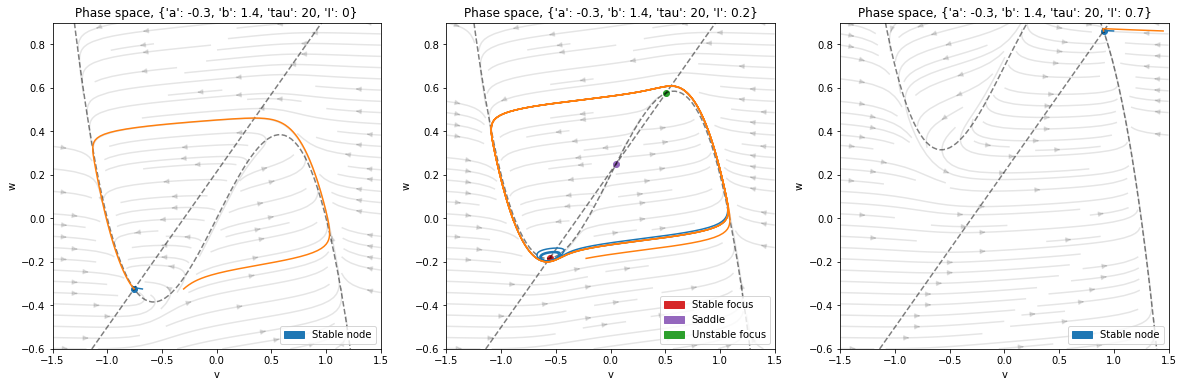

In [59]:
fig, ax = plt.subplots(1,3, figsize=(20, 6))
for i, param in enumerate(scenarios):
    plot_phase_diagram(param, ax[i])